# Data Loader

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# Importing Libraries
print('Importing Libraries... ',end='')
import os
from pathlib import Path
import pandas as pd
import torchaudio
import zipfile
from torchaudio.transforms import Resample
import IPython.display as ipd
from matplotlib import pyplot as plt
from tqdm import tqdm
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from torch.optim import Adam
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
print('Done')

Importing Libraries... Done


In [3]:
# Loading dataset
path = Path('./') #Please give your path here during run
df = pd.read_csv('./meta/esc50.csv')  #Please give your path here during run

Shape of waveform: torch.Size([1, 220500])
Sample rate of waveform: 44100


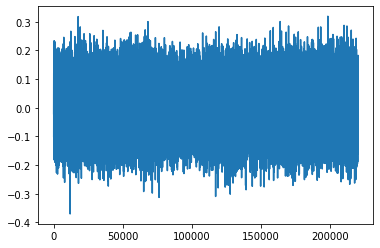

In [4]:
# Getting list of raw audio files
wavs = list(path.glob('audio/*'))  # List all audio files in the 'audio' directory using pathlib.Path.glob

# Visualizing data
waveform, sample_rate = torchaudio.load(wavs[0])  # Load the waveform and sample rate of the first audio file using torchaudio

print("Shape of waveform: {}".format(waveform.size()))  # Print the shape of the waveform tensor
print("Sample rate of waveform: {}".format(sample_rate))  # Print the sample rate of the audio file

# Plot the waveform using matplotlib
plt.figure()
plt.plot(waveform.t().numpy())  # Transpose and convert the waveform tensor to a NumPy array for plotting

# Display the audio using IPython.display.Audio
ipd.Audio(waveform, rate=sample_rate)  # Create an interactive audio player for the loaded waveform


In [5]:
class CustomDataset(Dataset):
    def __init__(self, dataset, **kwargs):
        # Initialize CustomDataset object with relevant parameters
        # dataset: "train", "val", or "test"
        # kwargs: Additional parameters like data directory, dataframe, folds, etc.

        # Extract parameters from kwargs
        self.data_directory = kwargs["data_directory"]
        self.data_frame = kwargs["data_frame"]
        self.validation_fold = kwargs["validation_fold"]
        self.testing_fold = kwargs["testing_fold"]
        self.esc_10_flag = kwargs["esc_10_flag"]
        self.file_column = kwargs["file_column"]
        self.label_column = kwargs["label_column"]
        self.sampling_rate = kwargs["sampling_rate"]
        self.new_sampling_rate = kwargs["new_sampling_rate"]
        self.sample_length_seconds = kwargs["sample_length_seconds"]

        # Filter dataframe based on esc_10_flag and data_type
        if self.esc_10_flag:
            self.data_frame = self.data_frame.loc[self.data_frame['esc10'] == True]

        if dataset == "train":
            self.data_frame = self.data_frame.loc[
                (self.data_frame['fold'] != self.validation_fold) & (self.data_frame['fold'] != self.testing_fold)]
        elif dataset == "val":
            self.data_frame = self.data_frame.loc[self.data_frame['fold'] == self.validation_fold]
        elif dataset == "test":
            self.data_frame = self.data_frame.loc[self.data_frame['fold'] == self.testing_fold]

        # Get unique categories from the filtered dataframe
        self.categories = sorted(self.data_frame[self.label_column].unique())

        # Initialize lists to hold file names, labels, and folder numbers
        self.file_names = []
        self.labels = []

        # Initialize dictionaries for category-to-index and index-to-category mapping
        self.category_to_index = {}
        self.index_to_category = {}

        for i, category in enumerate(self.categories):
            self.category_to_index[category] = i
            self.index_to_category[i] = category

        # Populate file names and labels lists by iterating through the dataframe
        for ind in tqdm(range(len(self.data_frame))):
            row = self.data_frame.iloc[ind]
            file_path = self.data_directory / "audio" / row[self.file_column]
            self.file_names.append(file_path)
            self.labels.append(self.category_to_index[row[self.label_column]])

        self.resampler = torchaudio.transforms.Resample(self.sampling_rate, self.new_sampling_rate)

        # Window size for rolling window sample splits (unfold method)
        if self.sample_length_seconds == 2:
            self.window_size = self.new_sampling_rate * 2
            self.step_size = int(self.new_sampling_rate * 0.75)
        else:
            self.window_size = self.new_sampling_rate
            self.step_size = int(self.new_sampling_rate * 0.5)

    def __getitem__(self, index):
        # Split audio files with overlap, pass as stacked tensors tensor with a single label
        path = self.file_names[index]
        audio_file = torchaudio.load(path, format=None, normalize=True)
        audio_tensor = self.resampler(audio_file[0])
        splits = audio_tensor.unfold(1, self.window_size, self.step_size)
        samples = splits.permute(1, 0, 2)

        labels = torch.tensor([self.labels[index]*samples.size(0),torch.dtype==torch.long])
        return samples, self.labels[index]

    def __len__(self):
        return len(self.file_names)


In [6]:
class CustomDataModule(pl.LightningDataModule):
    def __init__(self, **kwargs):
        # Initialize the CustomDataModule with batch size, number of workers, and other parameters
        super().__init__()
        self.batch_size = kwargs["batch_size"]
        self.num_workers = kwargs["num_workers"]
        self.data_module_kwargs = kwargs

    def setup(self, stage=None):
        # Define datasets for training, validation, and testing during Lightning setup

        # If in 'fit' or None stage, create training and validation datasets
        if stage == 'fit' or stage is None:
            self.training_dataset = CustomDataset(dataset="train", **self.data_module_kwargs)
            self.validation_dataset = CustomDataset(dataset="val", **self.data_module_kwargs)

        # If in 'test' or None stage, create testing dataset
        if stage == 'test' or stage is None:
            self.testing_dataset = CustomDataset(dataset="test", **self.data_module_kwargs)

    def train_dataloader(self):
        # Return DataLoader for training dataset
        return DataLoader(self.training_dataset,
                          batch_size=self.batch_size,
                          shuffle=True,
                          collate_fn=self.collate_function,
                          num_workers=self.num_workers)

    def val_dataloader(self):
        # Return DataLoader for validation dataset
        return DataLoader(self.validation_dataset,
                          batch_size=self.batch_size,
                          shuffle=False,
                          collate_fn=self.collate_function,
                          num_workers=self.num_workers)

    def test_dataloader(self):
        # Return DataLoader for testing dataset
        return DataLoader(self.testing_dataset,
                          batch_size=32,
                          shuffle=False,
                          collate_fn=self.collate_function,
                          num_workers=self.num_workers)

    def collate_function(self, data):
        """
        Collate function to process a batch of examples and labels.

        Args:
            data: a tuple of 2 tuples with (example, label) where
                example are the split 1 second sub-frame audio tensors per file
                label = the label

        Returns:
            A list containing examples (concatenated tensors) and labels (flattened tensor).
        """
        examples, labels = zip(*data)
        batch_size = len(examples)

        duplicated_labels = []
        for l in labels:
          duplicated_labels.extend([l]*len(examples[0]))

        examples_batch = torch.cat(examples)
        labels_batch = torch.tensor(duplicated_labels)

        return [examples_batch, labels_batch]


## Training CNN-Transformer Architecture with 4Heads with KFold

In [7]:
# Data Setup
def KFold(valid_samp):
    test_samp = 1 #""" Do not change this!! """
    valid_samp = valid_samp # Use any value ranging from 2 to 5 for k-fold validation (valid_fold)
    batch_size = 32 # Free to change
    num_workers = 8 # Free to change
    custom_data_module = CustomDataModule(batch_size=batch_size,
                                          num_workers=num_workers,
                                          data_directory=path,
                                          data_frame=df,
                                          validation_fold=valid_samp,
                                          testing_fold=test_samp,  # set to 0 for no test set
                                          esc_10_flag=True,
                                          file_column='filename',
                                          label_column='category',
                                          sampling_rate=44100,
                                          new_sampling_rate=16000,  # new sample rate for input
                                          sample_length_seconds=1  # new length of input in seconds
                                          )
    custom_data_module.setup()
    return custom_data_module

In [8]:
# Data Exploration
custom_data_module=KFold(2)
print('Class Label: ', custom_data_module.training_dataset[0][1])  # this prints the class label
print('Shape of data sample tensor: ', custom_data_module.training_dataset[0][0].shape)  # this prints the shape of the sample (Frames, Channel, Features)


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 4258.88it/s]


Class Label:  2
Shape of data sample tensor:  torch.Size([9, 1, 16000])


In [9]:
import torch.nn.functional as F

# Define your CNN model
class Custom_One_Dimension_ConvolutionModel(nn.Module):
    def __init__(self):
        super(Custom_One_Dimension_ConvolutionModel, self).__init__()
        self.conv1 = nn.Conv1d(1, 128, kernel_size=7, padding=3, stride=2)
        self.batch_norm1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(0.5)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv1d(128, 64, kernel_size=5, padding=2, stride=2)
        self.batch_norm2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(0.5)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv1d(64, 32, kernel_size=3, padding=1, stride=2)
        self.batch_norm3 = nn.BatchNorm1d(32)
        self.dropout3 = nn.Dropout(0.5)
        self.pool3 = nn.AvgPool1d(kernel_size=2, stride=2)

    def forward(self, z):
        z = F.relu(self.conv1(z))
        z = self.batch_norm1(z)
        z = self.dropout1(z)
        z = self.pool1(z)

        z = F.relu(self.conv2(z))
        z = self.batch_norm2(z)
        z = self.dropout2(z)
        z = self.pool2(z)

        z = F.relu(self.conv3(z))
        z = self.batch_norm3(z)
        z = self.dropout3(z)
        z = self.pool3(z)

        return z

# Define the custom MultiheadAttention module
class CustomMultiheadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.0):
        super(CustomMultiheadAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        self.in_proj_weight = nn.Parameter(torch.Tensor(3 * embed_dim, embed_dim))
        self.in_proj_bias = nn.Parameter(torch.Tensor(3 * embed_dim))
        self.out_proj = nn.Linear(embed_dim, embed_dim, bias=True)

        self.dropout = nn.Dropout(p=dropout)

        self._reset_parameters()

    def _reset_parameters(self):
        nn.init.xavier_uniform_(self.in_proj_weight)
        nn.init.constant_(self.in_proj_bias, 0.)
        nn.init.xavier_uniform_(self.out_proj.weight)
        nn.init.constant_(self.out_proj.bias, 0.)

    def forward(self, query, key, value, key_padding_mask=None, need_weights=True, attn_mask=None):
        tgt_len, bsz, embed_dim = query.size()
        assert embed_dim == self.embed_dim
        assert list(query.size()) == [tgt_len, bsz, embed_dim]
        assert key.size() == value.size()

        q, k, v = F.linear(query, self.in_proj_weight, self.in_proj_bias).chunk(3, dim=-1)

        q = q * (self.embed_dim ** -0.5)
        
        q=q[:,:,:248]
        k=k[:,:,:248]
        v=v[:,:,:248]

        q = q.contiguous().view(tgt_len, bsz * self.num_heads, self.head_dim).transpose(0, 1)
        k = k.contiguous().view(-1, bsz * self.num_heads, self.head_dim).transpose(0, 1)
        v = v.contiguous().view(-1, bsz * self.num_heads, self.head_dim).transpose(0, 1)

        src_len = k.size(1)

        attn_output_weights = torch.bmm(q, k.transpose(1, 2))
        attn_output_weights = attn_output_weights.view(bsz, self.num_heads, tgt_len, src_len)

        if attn_mask is not None:
            attn_output_weights += attn_mask

        attn_output_weights = F.softmax(attn_output_weights, dim=-1)
        attn_output_weights = self.dropout(attn_output_weights)
        
        attn_output = torch.bmm(attn_output_weights.view(bsz * self.num_heads, tgt_len, src_len), v)
        attn_output = attn_output.transpose(0, 1).contiguous().view(tgt_len, bsz, 248)
        additional_values = torch.zeros(tgt_len, bsz, 2).to(attn_output.device)
        attn_output = torch.cat((attn_output, additional_values), dim=-1)
        attn_output = self.out_proj(attn_output)
        return attn_output, attn_output_weights

# Define the custom Transformer encoder layer with <cls> token
class CustomTransformerEncoderLayerWithCLS(nn.Module):
    def __init__(self, dim_model, num_heads, dim_feedforward, dropout):
        super().__init__()
        self.self_attn = CustomMultiheadAttention(dim_model, num_heads, dropout=dropout)
        self.linear1 = nn.Linear(dim_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, dim_model)
        self.norm1 = nn.LayerNorm(dim_model)
        self.norm2 = nn.LayerNorm(dim_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, src):
        # Add <cls> token at the beginning
        cls_token = torch.zeros(src.size(0), 1, src.size(2)).to(src.device)
        src = torch.cat((cls_token, src), dim=1)

        # Transformer self-attention
        src2, _ = self.self_attn(src, src, src)
        src = src + self.dropout1(src2)
        src = self.norm1(src)

        # Position-wise feedforward
        src2 = self.linear2(self.dropout(F.relu(self.linear1(src))))
        src = src + self.dropout2(src2)
        src = self.norm2(src)

        return src

# Define the Transformer model with MLP head for classification
class TransformerClassifier(nn.Module):
    def __init__(self, cnn_model, num_classes, dim_model=512, num_heads=4, dim_feedforward=2048, dropout=0.1):
        super().__init__()
        self.cnn_model = cnn_model
        self.transformer_encoder = nn.Sequential(
            CustomTransformerEncoderLayerWithCLS(dim_model, num_heads, dim_feedforward, dropout),
            CustomTransformerEncoderLayerWithCLS(dim_model, num_heads, dim_feedforward, dropout)
            # Add more Transformer encoder layers as needed
        )
        self.mlp_head = nn.Linear(dim_model, num_classes)

    def forward(self, x):
        # Forward pass through CNN model
        features = self.cnn_model(x)
        # Forward pass through Transformer encoder
        encoded_features = self.transformer_encoder(features)
        # Take only the <cls> token
        cls_token = encoded_features[:, 0, :]
        # Classification using MLP head
        output = self.mlp_head(cls_token)
        return output

In [10]:
output_dim_cnn = 250  # Output dimension of your CNN model
num_classes = 10  # Number of classes in your classification task
cnn_model = Custom_One_Dimension_ConvolutionModel()
transformer_classifier_4Heads = TransformerClassifier(cnn_model, num_classes=num_classes, dim_model=output_dim_cnn)
# Define your optimizer and loss function
optimizer = torch.optim.Adam(transformer_classifier_4Heads.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

In [11]:
import wandb

In [12]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: gyanendrachaubey (gyanendrachaubeyproject). Use `wandb login --relogin` to force relogin


True

In [13]:
run = wandb.init()

In [14]:
# Training and Testing
epochs_num= 25
losses_train,losses_test, losses_valid= [], [], []
accuracies_train,accuracies_test, accuracies_valid= [], [], [] 

# early_stopping_rounds = 5
# min_val_loss = float('inf')
# early_stopping_counter = 0

for n_fold in range(2,6):
    print(f'K_fold= {n_fold-1} :')
    custom_data_module=KFold(n_fold)
    train_loader=custom_data_module.train_dataloader()
    val_loader=custom_data_module.val_dataloader()
    test_loader=custom_data_module.test_dataloader()
    for epoch in range(epochs_num):
      transformer_classifier_4Heads.train()
      loss_training= 0.0
      train_correct= 0
      train_total= 0
        
      #Training
      for inputs,labels in train_loader:
        #print(inputs.shape, labels.shape)
        optimizer.zero_grad()
        outputs= transformer_classifier_4Heads(inputs)
        #print(outputs.shape)
        loss= loss_func(outputs,labels)
        loss.backward()
        optimizer.step()

        loss_training+= loss.item()
        _,predicted= torch.max(outputs.data,1)
        train_total+= labels.size(0)
        train_correct+= (predicted==labels).sum().item()

      train_accuracy= train_correct/train_total
      losses_train.append(loss_training/len(train_loader))
      accuracies_train.append(train_accuracy)

      # Validation
      transformer_classifier_4Heads.eval()
      loss_valid= 0.0
      valid_correct= 0
      valid_total= 0

      with torch.no_grad():
        for inputs,labels in val_loader:
          outputs= transformer_classifier_4Heads(inputs)
          #print(outputs.shape)
          loss= loss_func(outputs,labels)
          loss_valid+= loss.item()
          _, predicted= torch.max(outputs.data,1)
          valid_total+= labels.size(0)
          valid_correct+= (predicted==labels).sum().item()

      valid_accuracy= valid_correct/valid_total
      losses_valid.append(loss_valid/len(val_loader))
      accuracies_valid.append(valid_accuracy)
      
      #Testing
      loss_test= 0.0
      test_correct= 0
      test_total= 0
      with torch.no_grad():
        for inputs,labels in test_loader:
          outputs= transformer_classifier_4Heads(inputs)
          #print(outputs.shape)
          loss= loss_func(outputs,labels)
          loss_test+= loss.item()
          _, predicted= torch.max(outputs.data,1)
          test_total+= labels.size(0)
          test_correct+= (predicted==labels).sum().item()

      test_accuracy= test_correct/test_total
      losses_test.append(loss_test/len(test_loader))
      accuracies_test.append(test_accuracy)

#       if loss_testing < min_val_loss:
#         min_val_loss = loss_testing
#         early_stopping_counter = 0
#       else:
#         early_stopping_counter += 1
#       if early_stopping_counter >= early_stopping_rounds:
#         print(f'Early stopping at epoch {epoch + 1}')
#         break

      print(f'Epoch {epoch+1}/{epochs_num}, '
            f'Train Loss: {losses_train[-1]:.4f}, Train Accuracy: {train_accuracy:.4f}, '
            f'Valid Loss: {losses_valid[-1]:.4f}, Valid Accuracy: {valid_accuracy:.4f},'
           f'Test Loss: {losses_test[-1]:.4f}, Test Accuracy: {test_accuracy:.4f}')
      wandb.log({'Train Loss': losses_train[-1], 'Train Accuracy': train_accuracy,
            'Valid Loss': losses_valid[-1], 'Valid Accuracy': valid_accuracy,
           'Test Loss': losses_test[-1], 'Test Accuracy': test_accuracy})

wandb.finish()

K_fold= 1 :


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 3325.65it/s]


Epoch 1/25, Train Loss: 3.2261, Train Accuracy: 0.0838, Valid Loss: 2.7253, Valid Accuracy: 0.1000,Test Loss: 2.6064, Test Accuracy: 0.1000
Epoch 2/25, Train Loss: 2.5042, Train Accuracy: 0.0889, Valid Loss: 2.3993, Valid Accuracy: 0.1000,Test Loss: 2.4714, Test Accuracy: 0.1000
Epoch 4/25, Train Loss: 2.3795, Train Accuracy: 0.0995, Valid Loss: 2.3427, Valid Accuracy: 0.1000,Test Loss: 2.3247, Test Accuracy: 0.1000
Epoch 5/25, Train Loss: 2.3346, Train Accuracy: 0.1009, Valid Loss: 2.3036, Valid Accuracy: 0.1000,Test Loss: 2.3247, Test Accuracy: 0.1000
Epoch 6/25, Train Loss: 2.3533, Train Accuracy: 0.0884, Valid Loss: 2.3259, Valid Accuracy: 0.1000,Test Loss: 2.3285, Test Accuracy: 0.1000
Epoch 7/25, Train Loss: 2.3548, Train Accuracy: 0.0870, Valid Loss: 2.3122, Valid Accuracy: 0.1000,Test Loss: 2.3155, Test Accuracy: 0.1000
Epoch 8/25, Train Loss: 2.3401, Train Accuracy: 0.0806, Valid Loss: 2.3236, Valid Accuracy: 0.1000,Test Loss: 2.3100, Test Accuracy: 0.1000
Epoch 9/25, Train Lo

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 5332.36it/s]


Epoch 1/25, Train Loss: 2.3629, Train Accuracy: 0.0699, Valid Loss: 2.3142, Valid Accuracy: 0.1000,Test Loss: 2.3185, Test Accuracy: 0.1000
Epoch 2/25, Train Loss: 2.3349, Train Accuracy: 0.0907, Valid Loss: 2.3291, Valid Accuracy: 0.1000,Test Loss: 2.3133, Test Accuracy: 0.1000
Epoch 3/25, Train Loss: 2.3319, Train Accuracy: 0.0931, Valid Loss: 2.3005, Valid Accuracy: 0.1000,Test Loss: 2.3123, Test Accuracy: 0.1000
Epoch 4/25, Train Loss: 2.3434, Train Accuracy: 0.0935, Valid Loss: 2.3077, Valid Accuracy: 0.1000,Test Loss: 2.3031, Test Accuracy: 0.1000
Epoch 5/25, Train Loss: 2.3371, Train Accuracy: 0.0796, Valid Loss: 2.3167, Valid Accuracy: 0.1000,Test Loss: 2.3237, Test Accuracy: 0.1000
Epoch 6/25, Train Loss: 2.3248, Train Accuracy: 0.0977, Valid Loss: 2.2930, Valid Accuracy: 0.1000,Test Loss: 2.3038, Test Accuracy: 0.1000
Epoch 7/25, Train Loss: 2.3392, Train Accuracy: 0.0870, Valid Loss: 2.3120, Valid Accuracy: 0.1000,Test Loss: 2.3036, Test Accuracy: 0.1000
Epoch 8/25, Train Lo

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 4922.03it/s]


Epoch 1/25, Train Loss: 2.3268, Train Accuracy: 0.1042, Valid Loss: 2.3080, Valid Accuracy: 0.1000,Test Loss: 2.3069, Test Accuracy: 0.1000
Epoch 2/25, Train Loss: 2.3253, Train Accuracy: 0.0750, Valid Loss: 2.3079, Valid Accuracy: 0.1000,Test Loss: 2.3053, Test Accuracy: 0.1000
Epoch 3/25, Train Loss: 2.3421, Train Accuracy: 0.0866, Valid Loss: 2.3091, Valid Accuracy: 0.1000,Test Loss: 2.3121, Test Accuracy: 0.1000
Epoch 4/25, Train Loss: 2.3289, Train Accuracy: 0.0884, Valid Loss: 2.3193, Valid Accuracy: 0.1000,Test Loss: 2.3196, Test Accuracy: 0.1000
Epoch 5/25, Train Loss: 2.3314, Train Accuracy: 0.0958, Valid Loss: 2.3057, Valid Accuracy: 0.1000,Test Loss: 2.3036, Test Accuracy: 0.1000
Epoch 6/25, Train Loss: 2.3202, Train Accuracy: 0.0935, Valid Loss: 2.3112, Valid Accuracy: 0.1000,Test Loss: 2.3150, Test Accuracy: 0.1000
Epoch 7/25, Train Loss: 2.3227, Train Accuracy: 0.0958, Valid Loss: 2.3139, Valid Accuracy: 0.1000,Test Loss: 2.3184, Test Accuracy: 0.1000
Epoch 8/25, Train Lo

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 4423.03it/s]


Epoch 1/25, Train Loss: 2.3278, Train Accuracy: 0.0995, Valid Loss: 2.3124, Valid Accuracy: 0.1000,Test Loss: 2.3106, Test Accuracy: 0.1000
Epoch 2/25, Train Loss: 2.3296, Train Accuracy: 0.0866, Valid Loss: 2.3186, Valid Accuracy: 0.1000,Test Loss: 2.3211, Test Accuracy: 0.1000
Epoch 3/25, Train Loss: 2.3229, Train Accuracy: 0.0898, Valid Loss: 2.3030, Valid Accuracy: 0.1000,Test Loss: 2.3026, Test Accuracy: 0.1000
Epoch 4/25, Train Loss: 2.3364, Train Accuracy: 0.0796, Valid Loss: 2.3085, Valid Accuracy: 0.1000,Test Loss: 2.3090, Test Accuracy: 0.1000
Epoch 5/25, Train Loss: 2.3249, Train Accuracy: 0.0991, Valid Loss: 2.3174, Valid Accuracy: 0.1000,Test Loss: 2.3140, Test Accuracy: 0.1000
Epoch 6/25, Train Loss: 2.3283, Train Accuracy: 0.0926, Valid Loss: 2.3014, Valid Accuracy: 0.1000,Test Loss: 2.3079, Test Accuracy: 0.1000
Epoch 7/25, Train Loss: 2.3386, Train Accuracy: 0.0796, Valid Loss: 2.3163, Valid Accuracy: 0.1000,Test Loss: 2.3101, Test Accuracy: 0.1000
Epoch 8/25, Train Lo

Test Accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Test Loss,█▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▄▄▅▃▃▃▂▆▆▄▁▆▇▂▇▆▇▆▃▂█▅▆▅▇▇▅▃▄▄▄▃▃▅▄▅▄▆▄▇
Train Loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Valid Accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Valid Loss,█▂▂▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Test Accuracy,0.1
Test Loss,2.30719
Train Accuracy,0.10139
Train Loss,2.32134
Valid Accuracy,0.1


### Confusion Matrix for CNN with K-fold

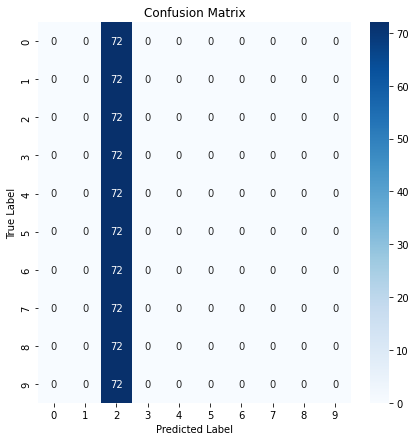

In [16]:
transformer_classifier_4Heads.eval()
all_preds,all_labels= [], []
classes=['0','1','2','3','4','5','6','7','8','9']

with torch.no_grad():
  for inputs,labels in test_loader:
    outputs= transformer_classifier_4Heads(inputs)
    _, preds= torch.max(outputs,1)
    all_preds.extend(preds.tolist())
    all_labels.extend(labels.tolist())

cm= confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(7,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### Accuracy Score of CNN with K-fold

In [17]:
accuracy_score(all_labels,all_preds)

0.1

### F1-score of CNN with K-fold

In [18]:
f1_score(all_labels, all_preds, average=None)

array([0.        , 0.        , 0.18181818, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

### ROC-AUC Curve of CNN with K-fold

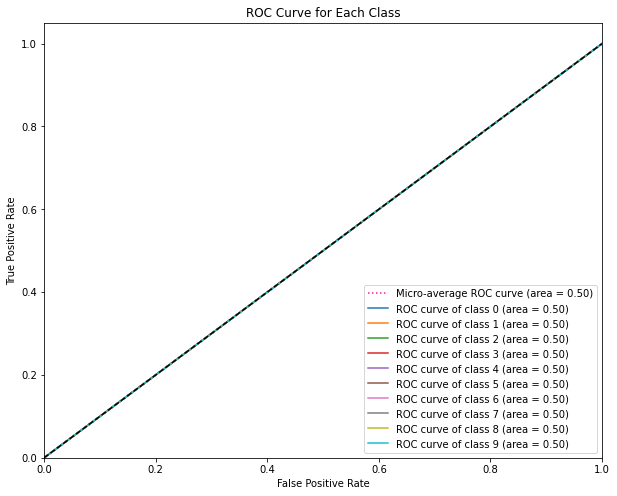

In [19]:
import numpy as np
from sklearn.metrics import roc_curve, auc

# Convert true labels to one-hot encoding
one_hot_labels = np.eye(len(classes))[np.array(all_labels)]

# Convert predicted labels to one-hot encoding
one_hot_preds = np.eye(len(classes))[np.array(all_preds)]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(one_hot_labels[:, i], one_hot_preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr_micro, tpr_micro, _ = roc_curve(one_hot_labels.ravel(), one_hot_preds.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
plt.plot(fpr_micro, tpr_micro, label='Micro-average ROC curve (area = {0:0.2f})'.format(roc_auc_micro), color='deeppink', linestyle=':')
for i in range(len(classes)):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(classes[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend(loc="lower right")
plt.show()

## Training CNN with Train_Test

In [20]:
custom_data_module=KFold(2)

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 4734.98it/s]


In [21]:
train_loader=custom_data_module.train_dataloader()
test_loader=custom_data_module.test_dataloader()

In [26]:
output_dim_cnn = 250  # Output dimension of your CNN model
num_classes = 10  # Number of classes in your classification task
cnn_model = Custom_One_Dimension_ConvolutionModel()
transformer_classifier_4Heads_train_test = TransformerClassifier(cnn_model, num_classes=num_classes, dim_model=output_dim_cnn)
# Define your optimizer and loss function
optimizer = torch.optim.Adam(transformer_classifier_4Heads.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

In [27]:
run = wandb.init()

In [28]:
# Training and Testing
epochs_num= 25
losses_train,losses_test= [], []
accuracies_train,accuracies_test= [], [] 

for epoch in range(epochs_num):
  transformer_classifier_4Heads_train_test.train()
  loss_training= 0.0
  train_correct= 0
  train_total= 0

  for inputs,labels in train_loader:
    #print(inputs.shape, labels.shape)
    optimizer.zero_grad()
    outputs= transformer_classifier_4Heads_train_test(inputs)
    #print(outputs.shape)
    loss= loss_func(outputs,labels)
    loss.backward()
    optimizer.step()

    loss_training+= loss.item()
    _,predicted= torch.max(outputs.data,1)
    train_total+= labels.size(0)
    train_correct+= (predicted==labels).sum().item()

  train_accuracy= train_correct/train_total
  losses_train.append(loss_training/len(train_loader))
  accuracies_train.append(train_accuracy)

  # Validation
  transformer_classifier_4Heads_train_test.eval()
  loss_testing= 0.0
  test_correct= 0
  test_total= 0

  with torch.no_grad():
    for inputs,labels in test_loader:
      outputs= transformer_classifier_4Heads_train_test(inputs)
      #print(outputs.shape)
      loss= loss_func(outputs,labels)
      loss_testing+= loss.item()
      _, predicted= torch.max(outputs.data,1)
      test_total+= labels.size(0)
      test_correct+= (predicted==labels).sum().item()

  test_accuracy= test_correct/test_total
  losses_test.append(loss_testing/len(test_loader))
  accuracies_test.append(test_accuracy)

  print(f'Epoch {epoch+1}/{epochs_num}, '
        f'Train Loss: {losses_train[-1]:.4f}, Train Accuracy: {train_accuracy:.4f}, '
        f'Test Loss: {losses_test[-1]:.4f}, Test Accuracy: {test_accuracy:.4f}')

wandb.finish()

Epoch 1/25, Train Loss: 2.4765, Train Accuracy: 0.1056, Test Loss: 2.4669, Test Accuracy: 0.1000
Epoch 2/25, Train Loss: 2.4727, Train Accuracy: 0.0972, Test Loss: 2.4669, Test Accuracy: 0.1000
Epoch 3/25, Train Loss: 2.4977, Train Accuracy: 0.0995, Test Loss: 2.4669, Test Accuracy: 0.1000
Epoch 4/25, Train Loss: 2.4578, Train Accuracy: 0.0972, Test Loss: 2.4669, Test Accuracy: 0.1000
Epoch 5/25, Train Loss: 2.4945, Train Accuracy: 0.0981, Test Loss: 2.4669, Test Accuracy: 0.1000
Epoch 6/25, Train Loss: 2.4568, Train Accuracy: 0.0963, Test Loss: 2.4669, Test Accuracy: 0.1000
Epoch 7/25, Train Loss: 2.4725, Train Accuracy: 0.0995, Test Loss: 2.4669, Test Accuracy: 0.1000
Epoch 8/25, Train Loss: 2.4549, Train Accuracy: 0.0981, Test Loss: 2.4669, Test Accuracy: 0.1000
Epoch 9/25, Train Loss: 2.4698, Train Accuracy: 0.0958, Test Loss: 2.4669, Test Accuracy: 0.1000
Epoch 10/25, Train Loss: 2.4703, Train Accuracy: 0.0986, Test Loss: 2.4669, Test Accuracy: 0.1000
Epoch 11/25, Train Loss: 2.47

### Confusion Matrix for CNN with TrainTestSplit

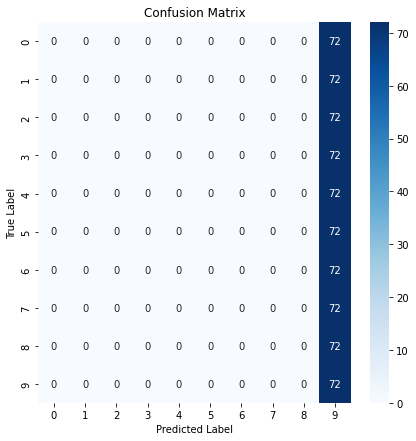

In [31]:
transformer_classifier_4Heads_train_test.eval()
all_preds,all_labels= [], []
classes=['0','1','2','3','4','5','6','7','8','9']

with torch.no_grad():
  for inputs,labels in test_loader:
    outputs= transformer_classifier_4Heads_train_test(inputs)
    _, preds= torch.max(outputs,1)
    all_preds.extend(preds.tolist())
    all_labels.extend(labels.tolist())

cm= confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(7,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### Accuracy Score of CNN with TrainTestSplit

In [32]:
accuracy_score(all_labels,all_preds)

0.1

### F1-score of CNN with TrainTestSplit

In [33]:
f1_score(all_labels, all_preds, average=None)

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.18181818])

### ROC-AUC Curve of CNN with TrainTestSplit

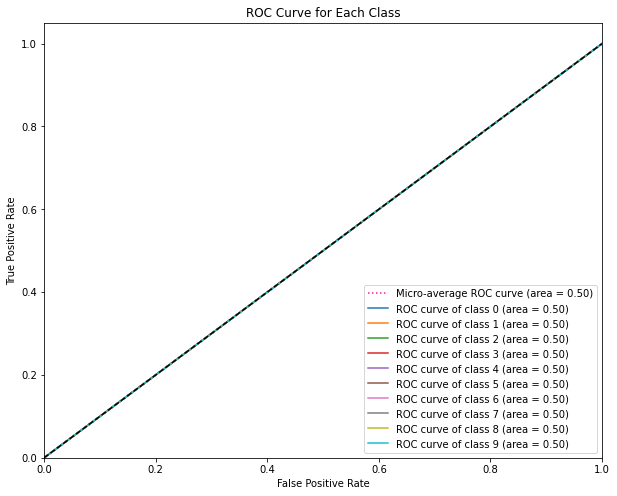

In [34]:
import numpy as np
from sklearn.metrics import roc_curve, auc

# Convert true labels to one-hot encoding
one_hot_labels = np.eye(len(classes))[np.array(all_labels)]

# Convert predicted labels to one-hot encoding
one_hot_preds = np.eye(len(classes))[np.array(all_preds)]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(one_hot_labels[:, i], one_hot_preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr_micro, tpr_micro, _ = roc_curve(one_hot_labels.ravel(), one_hot_preds.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
plt.plot(fpr_micro, tpr_micro, label='Micro-average ROC curve (area = {0:0.2f})'.format(roc_auc_micro), color='deeppink', linestyle=':')
for i in range(len(classes)):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(classes[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend(loc="lower right")
plt.show()